# بيتر والذئب: بيئة واقعية

في حالتنا، كان بيتر قادرًا على التحرك تقريبًا دون أن يشعر بالتعب أو الجوع. في عالم أكثر واقعية، عليه أن يجلس للراحة من وقت لآخر، وأيضًا أن يطعم نفسه. دعونا نجعل عالمنا أكثر واقعية من خلال تطبيق القواعد التالية:

1. عند الانتقال من مكان إلى آخر، يفقد بيتر **الطاقة** ويكتسب بعض **الإرهاق**.
2. يمكن لبيتر استعادة المزيد من الطاقة عن طريق تناول التفاح.
3. يمكن لبيتر التخلص من الإرهاق عن طريق الراحة تحت الشجرة أو على العشب (أي المشي إلى موقع على اللوحة يحتوي على شجرة أو عشب - حقل أخضر).
4. يحتاج بيتر إلى العثور على الذئب وقتله.
5. لكي يتمكن بيتر من قتل الذئب، يجب أن يكون لديه مستويات معينة من الطاقة والإرهاق، وإلا فإنه سيخسر المعركة.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math
from rlboard import *

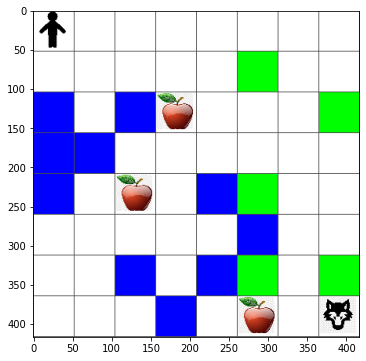

In [2]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

In [3]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

## تعريف الحالة

في قواعد لعبتنا الجديدة، نحتاج إلى تتبع الطاقة والإرهاق في كل حالة من حالات اللوحة. لذلك، سنقوم بإنشاء كائن `state` الذي سيحمل جميع المعلومات المطلوبة حول حالة المشكلة الحالية، بما في ذلك حالة اللوحة، ومستويات الطاقة والإرهاق الحالية، وما إذا كان بإمكاننا التغلب على الذئب أثناء الحالة النهائية:


In [4]:
class state:
    def __init__(self,board,energy=10,fatigue=0,init=True):
        self.board = board
        self.energy = energy
        self.fatigue = fatigue
        self.dead = False
        if init:
            self.board.random_start()
        self.update()

    def at(self):
        return self.board.at()

    def update(self):
        if self.at() == Board.Cell.water:
            self.dead = True
            return
        if self.at() == Board.Cell.tree:
            self.fatigue = 0
        if self.at() == Board.Cell.apple:
            self.energy = 10

    def move(self,a):
        self.board.move(a)
        self.energy -= 1
        self.fatigue += 1
        self.update()

    def is_winning(self):
        return self.energy > self.fatigue

دعونا نحاول حل المشكلة باستخدام المشي العشوائي ونرى ما إذا كنا سننجح:


In [5]:
def random_policy(state):
    return random.choice(list(actions))

def walk(board,policy):
    n = 0 # number of steps
    s = state(board)
    while True:
        if s.at() == Board.Cell.wolf:
            if s.is_winning():
                return n # success!
            else:
                return -n # failure!
        if s.at() == Board.Cell.water:
            return 0 # died
        a = actions[policy(m)]
        s.move(a)
        n+=1

walk(m,random_policy)

0

In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        elif z==0:
            n+=1
        else:
            s+=1
    print(f"Killed by wolf = {w}, won: {s} times, drown: {n} times")

print_statistics(random_policy)

Killed by wolf = 5, won: 1 times, drown: 94 times


## وظيفة المكافأة



In [7]:
def reward(s):
    r = s.energy-s.fatigue
    if s.at()==Board.Cell.wolf:
        return 100 if s.is_winning() else -100
    if s.at()==Board.Cell.water:
        return -100
    return r

## خوارزمية Q-Learning

تظل خوارزمية التعلم الفعلية دون تغيير كبير، نحن فقط نستخدم `state` بدلاً من مجرد موقع اللوحة.


In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

In [9]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

In [10]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    s = state(m)
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = s.board.human
        v = probs(Q[x,y])
        while True:
            a = random.choices(list(actions),weights=v)[0]
            dpos = actions[a]
            if s.board.is_valid(s.board.move_pos(s.board.human,dpos)):
                break 
        s.move(dpos)
        r = reward(s)
        if abs(r)==100: # end of game
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

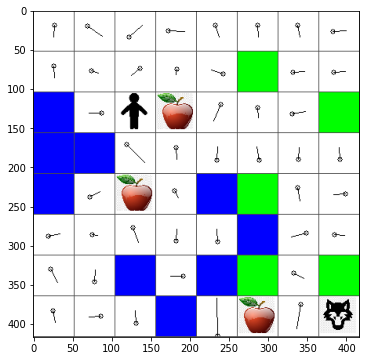

In [11]:
m.plot(Q)

## النتائج

لنرى ما إذا كنا قد نجحنا في تدريب بيتر على مواجهة الذئب!


In [12]:
def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Killed by wolf = 1, won: 9 times, drown: 90 times


نرى الآن حالات غرق أقل بكثير، لكن بيتر لا يزال غير قادر دائمًا على قتل الذئب. حاول التجربة ومعرفة ما إذا كان بإمكانك تحسين هذه النتيجة من خلال التلاعب بالمعاملات الفائقة.


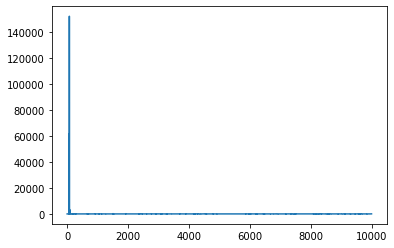

In [13]:
plt.plot(lpath)


---

**إخلاء المسؤولية**:  
تمت ترجمة هذا المستند باستخدام خدمة الترجمة بالذكاء الاصطناعي [Co-op Translator](https://github.com/Azure/co-op-translator). بينما نسعى لتحقيق الدقة، يرجى العلم أن الترجمات الآلية قد تحتوي على أخطاء أو معلومات غير دقيقة. يجب اعتبار المستند الأصلي بلغته الأصلية هو المصدر الموثوق. للحصول على معلومات حساسة أو هامة، يُوصى بالاستعانة بترجمة بشرية احترافية. نحن غير مسؤولين عن أي سوء فهم أو تفسيرات خاطئة ناتجة عن استخدام هذه الترجمة.
